In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3
from tqdm import tqdm
import imageio as im
from IPython.display import Image
import cv2
import time
from multiprocessing import Pool

In [2]:
global G
G = 6.7e-11 # Newton gravitational constant
m_to_AU = 6.68459e-12 #meter to AU conversion 

In [3]:
class body:
    def __init__(self,index,pos=np.array([0.0001,0,0]),radius=0,mass=0,vel=np.array([0,0,0]),
                 momentum=np.array([0,0,0]),get_e=0,center_body=0
                 ,get_inclination=0,get_obliq=0,get_prec=0,s=1,c='k'):
        self.index = index
        self.s = s #point size on graph
        self.c = c #color on graph
        
        #scalar quantities
        self.radius = radius
        self.mass = mass

        #vector quantities
        self.pos = pos
        self.vel = vel
        self.momentum = momentum

        #Body's position vectors
        #These vectors point from this body to all other bodies in the system
        self.r = []
        self.r_hat = []
        self.r_mag = []
        
        #arrays to track vector quantities
        self.posA = []
        self.momentumA = []
        
        #Current force on body:
        self.current_F = np.zeros(3)
        
        #Eccentricity and orbital shape
        self.e_vec = np.zeros(3)
        self.center_body = center_body #which other body in teh system I want the eccentricity relative to
        self.r_apoapsis = np.zeros(3)
        self.apoapsis_mag = np.linalg.norm(self.r_apoapsis)
        self.r_periapsis = np.array([1e20,1e20,1e20])
        self.periapsis_mag = np.linalg.norm(self.r_periapsis)
        self.e = (self.apoapsis_mag-self.periapsis_mag)/(self.apoapsis_mag+self.periapsis_mag)
        self.eA = []
        self.get_e = get_e
        
        self.semimajor = self.apoapsis_mag - self.periapsis_mag
        
        self.year = 0
        
        #For some bodies that have useful orbital inclinations
        self.get_inclination = get_inclination
        self.inclination = 0
        self.inclinationA = []
        
        #obliquity
        self.get_obliq = get_obliq
        self.obliquity = 0
        self.obliq_A = []
        
        #precession
        self.get_prec = get_prec
        self.precession = 0 #in degrees
        self.precessionA = []
    
    #Initiate Momentum - get the initial momentum array
    def init_momentum(self,verbose=0):
        self.momentum = self.vel*self.mass
        if verbose:
            print("Current momentum: ",self.momentum)
    
    ##################################################################
    #Update functions
    ##################################################################
    def update_momentum(self,dt,verbose=0):
        self.momentum = self.momentum + self.current_F*dt
        if verbose:
            print("Current momentum: ",self.momentum)
    
    def update_pos(self,dt,verbose=0):
        self.pos = self.pos + (self.momentum / self.mass) * dt
        if verbose:
            print("Current position: ",self.pos)
            
    #Updates orbital shape parameters, like eccentricity, apoapsis and periapsis, semimajor axis, and inclination
    def update_orbit_shape(self,c_body):
        if self.get_e:
            #ECCENTRICITY, APOAPSIS, PERIAPSIS, SEMIMAJOR
            #get the periapsis and apoapsis of the planet around its central body
            #If current point is farther than farthest point; new apoapsis
            if self.r_mag[self.center_body] > self.apoapsis_mag:
                self.r_apoapsis = self.pos - c_body.pos
                self.apoapsis_mag = np.linalg.norm(self.r_apoapsis)

            #If current point is closer than closest point; new periapsis
            if self.r_mag[self.center_body] < self.periapsis_mag:
                self.r_periapsis = self.pos - c_body.pos
                self.periapsis_mag = np.linalg.norm(self.r_periapsis)

            #Update the samimajor axis length!
            self.semimajor = (self.apoapsis_mag + self.periapsis_mag)/2 #average of the periapsis and apoapsis distance
            
            self.year = (( (self.periapsis_mag*m_to_AU) + (self.apoapsis_mag*m_to_AU) )/(2))**(3/2) #2*np.pi*np.sqrt(self.semimajor**3 / (G*self.mass))

            self.update_eccentricity(c_body)

        #If this body is tracking inclination, update the inclination!
        if self.get_inclination:
            self.inclination = get_angle_from_flat(self,c_body) #get_angle gives degrees
    
    #Update the tracking arrays
    def update_arrays(self,t):
        self.posA.append(self.pos)
        self.momentumA.append(self.momentum)

        #If this body is tracking inclination:
        if self.get_inclination:
            self.inclinationA.append(self.inclination) #in degrees

        #If this body is tracking obliquity:
        if self.get_obliq:
            self.obliquity = obliquity(t/(np.pi*1e7))
            self.obliq_A.append(self.obliquity)

        #If this body is tracking eccentricity and orbital shape:
        if self.get_e:
            self.eA.append(self.e)

        #If this body is tracking precession
        if self.get_prec:
            self.precessionA.append(self.precession)
    
    #Update the eccentricity
    def update_eccentricity(self,c_body,verbose=0):
        v_rel = -self.vel + c_body.vel
        r_rel = -self.pos + c_body.pos
        mu = G*self.mass
        
        self.e = (self.apoapsis_mag-self.periapsis_mag)/(self.apoapsis_mag+self.periapsis_mag)
        if verbose:
            print("Magnitude: ",self.e)  


In [4]:
def full_plot(bodies,azim,elev,xlim=1e12,ylim=1e12,zlim=1e12):
    fig = plt.figure(figsize=[15,15])

    ax = fig.add_subplot(111, projection='3d')
    #ybound = 147.23e9
    numpoints= int(len(star.posA)/1)
    for i in range(0,len(bodies)):
        ax.scatter( [item[0] for item in bodies[i].posA][-numpoints:] , [item[1] for item in bodies[i].posA][-numpoints:] 
                   , [item[2] for item in bodies[i].posA][-numpoints:],s=bodies[i].s,c=bodies[i].c)
        if bodies[i].get_e == 1:
            ax.scatter(bodies[i].r_apoapsis[0],bodies[i].r_apoapsis[1],bodies[i].r_apoapsis[2],s = 50,c='k',marker='v')
            ax.scatter(bodies[i].r_periapsis[0],bodies[i].r_periapsis[1],bodies[i].r_periapsis[2],s = 50,c='k',marker='^')
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    ax.set_zlabel("Z axis")
#     ax.set_xlim(-xlim,xlim)
#     ax.set_ylim(-ylim,ylim)
#     ax.set_zlim(-zlim,zlim)
    ax.view_init(azim=azim, elev=elev)

In [5]:
#Gets the planet's precession. This is specific to the planet.
def get_precession(star,planet,moon,dt,verbose=0):
    mu_s = G*star.mass #standard gravitational parameter
    mu_m = G*moon.mass #same for the moon
    a = planet.radius #equitorial radius
    c = planet.radius*(1-0.0033) #polar radius
    CAC =  (a**2 - c**2) / (a**2 + c**2)#0.003358481 #third eccentricity squared
    
    e = planet.e #eccentricity of planet around star, approx 0.01
    moon_e = moon.e #0.00661 #eccentricity of moon around planet, found from a sim of just planet and moon
    epsilon = planet.obliquity*(np.pi/180) #obliquity
    a_s = planet.semimajor #semimajor axis of planet-star orbit
    moon_semimajor = moon.semimajor #3.8e8 #5102661 #semimajor axis of moon-planet orbit, from separate sim with just planet and moon
    
    w = 7.2921159e-5 #earth's angular velocity, radians/second
    
    i = moon.inclination*(np.pi/180) #moon's inclination relative to the plane of the planet, originally in degrees. Converted to radians.
    
    if verbose:
        print("mu_s = ",mu_s,"\n mus_m = ",mu_m,"\n planet.e = ",e,"\n epsilon = ",epsilon,"\n a_s = ",a_s,"\n w = ",w,"\n i = ",i)
    
    planet_component = (CAC*np.cos(epsilon)/w )
    star_component = (3/2)*( mu_s/ (a_s**3 * (1-e**2)**(3/2) ) )*planet_component
    moon_component = (3/2)*( mu_m*(1-1.5*np.sin(i)**2) / (moon_semimajor**3 * (1-moon_e**2)**(3/2) ) )*planet_component
    
    #precession is in cycles/s right now, conversion to arcseconds/s:
    # precession [/s] * (1.3e6 / (2*pi)) [arcseconds / 2pi]
    #convert to degrees / sec: value / 3600
    
    #so, combining these: precession*( 1.296e6 / 2*pi )/3600 = degrees/s
    
    if verbose:
        print("planet_component: ",planet_component)
        print("star_comp: ",star_component)
        print("moon_comp: ",moon_component)
    
    dpsidt = (star_component+moon_component)*(1.296e6 / (np.pi*2))/3600
    dpsi = dpsidt*dt
    planet.precession = planet.precession + dpsi

    if verbose:
        print("Precession d-psi-dt = ",dpsidt)
        print("Precession new = ",planet.precession)

In [6]:
#Uses Kepler's third law to determine the initial velocity needed for a circular orbit
def get_orbit_vel(body_center,body_orbit,direction=np.array([0,0,0]),verbose=0):
    #Keppler's third law
    vel = direction*np.sqrt( (G*(body_center.mass)) / body_orbit.r_mag[body_center.index] )
    
    if verbose:
        print("Velocity for circular orbit: ",vel)
    return vel

In [23]:
def get_force_vectors(bodies,verbose=0):
    for i in range(0,len(bodies)):

        if verbose:
            print("Getting force vector on body ",i)

        for j in range(i,len(bodies)):
            if i != j:
                if verbose:
                    print("\tby body ",j)

                F_j_on_i = G * bodies[i].mass * bodies[j].mass * bodies[i].r_hat[bodies[j].index] / (bodies[i].r_mag[bodies[j].index])**2
                F_i_on_j = -F_j_on_i

                bodies[i].current_F = bodies[i].current_F + F_j_on_i
                bodies[j].current_F = bodies[j].current_F + F_i_on_j
        if verbose:
            print("Current force on object ",bodies[i].index,": ",bodies[i].current_F)
        if i != 0:
            bodies[i].update_momentum(dt)

In [24]:
def get_angle_from_flat(body,c_body):
    body_relative_z = ( body.pos[2]-c_body.pos[2])
    body_xy = np.sqrt(  (body.pos[0]-c_body.pos[0])**2 + (body.pos[1]-c_body.pos[1])**2  )
    #c_body_xy = np.sqrt(c_body.pos[0]**2 + c_body.pos[1]**2)
    #body_relative_xy = body_xy-c_body_xy
    #print("Relative position in xy plane: ",body_xy)
    return np.arctan( body_relative_z / body_xy )*(180/np.pi)

In [25]:
def get_position_vectors(bodies,verbose=0):
    #initialize the r vector sizes
    #I want each one to be the length of all objects in the system
    #even though this wastes a little space it will make index control much easier
    if verbose:
        print("Number of bodies: ",len(bodies))
    for body_i in range(0,len(bodies)):
        bodies[body_i].r = np.zeros([len(bodies),3])
        bodies[body_i].r_mag = np.zeros(len(bodies))
        bodies[body_i].r_hat = np.zeros([len(bodies),3])
    
    #get vectors defining the relative position of each body to each other body
    for body_i in range(0,len(bodies)):
        
        if verbose:
            print("Getting vectors for body ",body_i)
        
        for body_j in range(body_i,len(bodies)):
            #if we're not looking at the same body:
            if body_i != body_j:
                
                if verbose:
                    print("\tRelative to body ",body_j)
                
                #Get the vector pointing from body_i to all body j
                body_i_to_j = np.array(bodies[body_j].pos - bodies[body_i].pos)
                body_j_to_i = -body_i_to_j
                
                #Append them to the body's object paramters along with the
                #index of the body they are relevant to
                bodies[body_i].r[bodies[body_j].index] = body_i_to_j
                bodies[body_j].r[bodies[body_i].index] = body_j_to_i

                #The magnitudes of the vectors:
                bodies[body_i].r_mag[bodies[body_j].index] = np.linalg.norm( body_i_to_j )
                bodies[body_j].r_mag[bodies[body_i].index] = np.linalg.norm( body_j_to_i )
   
                #units of the vectors:
                bodies[body_i].r_hat[bodies[body_j].index] = body_i_to_j / bodies[body_i].r_mag[bodies[body_j].index]
                bodies[body_j].r_hat[bodies[body_i].index] = body_j_to_i / bodies[body_j].r_mag[bodies[body_i].index]

In [26]:
def integration(bodies,dt,years,tA=[],downsample=100,verbose=0):
    tA.remove(0)
    #BA = []
    #projectionmag = []

    dt = dt
    t=0
    tA = tA


    sim_len = years*np.pi*1e7
    while t < sim_len:
        #Update the position and momentum arrays for each body
        for i in range(0,len(bodies)):
            bodies[i].update_orbit_shape(bodies[bodies[i].center_body])

            if bodies[i].get_prec ==1 and t != 0:
                get_precession(bodies[0],bodies[i],bodies[i+1],dt)
                
            #Append to arrays, based on downsample rate
            #Update arrays based on downsample rate
            if t != 0 and int(t/dt) % downsample == 0:
                tA.append(t)
                if verbose:
                    print("Iteration number: ",t/dt)
                    
                bodies[i].update_arrays(t)

        #Update the position vectors
        get_position_vectors(bodies,verbose=0)
        
        #Get the forces between the bodies
        #zero out the current forces:
#         for i in range(0,len(bodies)):
#             bodies[i].current_F = np.zeros(3)
        get_force_vectors(bodies,verbose=0)
#         for i in range(0,len(bodies)):

#             if verbose:
#                 print("Getting force vector on body ",i)
                
#             for j in range(i,len(bodies)):
#                 if i != j:
#                     if verbose:
#                         print("\tby body ",j)
                        
#                     F_j_on_i = G * bodies[i].mass * bodies[j].mass * bodies[i].r_hat[bodies[j].index] / (bodies[i].r_mag[bodies[j].index])**2
#                     F_i_on_j = -F_j_on_i
                    
#                     bodies[i].current_F = bodies[i].current_F + F_j_on_i
#                     bodies[j].current_F = bodies[j].current_F + F_i_on_j
#             if verbose:
#                 print("Current force on object ",bodies[i].index,": ",bodies[i].current_F)
#             if i != 0:
#                 bodies[i].update_momentum(dt)
            
        for i in range(0,len(bodies)):
            bodies[i].update_pos(dt)

        t = t+dt

In [27]:
#Orbital Obliquity

#The amplitude of the sin wave varies over time,creating variability packets within the obliquity
def obliq_amp(t):
    amp_amp1 = 0.21
    amp_freq1 = 2*np.pi*(1/69000)
    return amp_amp1*np.sin(amp_freq1*t)

def obliquity(t):
    obliq_max = 29.82 #maximum axial tilt in degrees
    obliq_min = 22.82 #minimum axial tilt in degrees
    obliq_amp_base = (obliq_max-obliq_min)/2.0
    obliq_lam = 40000 #in years
    obliq_frequency = 2*np.pi*(1/obliq_lam)
    
    return (obliq_amp_base+obliq_amp(t) )*np.sin(obliq_frequency*t+np.pi/3-7*np.pi/20)+(obliq_max+obliq_min)/2.0

# Begin

Text(0.5, 0, 'Z axis')

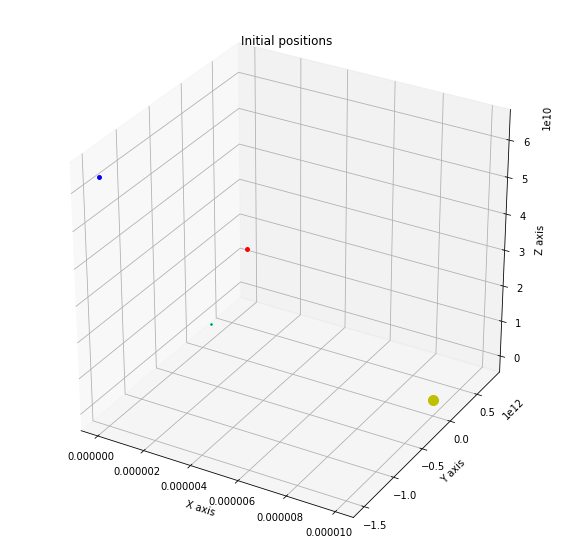

In [28]:
starPos = np.array([0.00001,0,0]) #initial position array for star; x,y,z components
starRadius = 6.9634e8 #radius in meters
starMass = 1.989e30 #mass of sun in kg
star = body(index=0,pos=starPos,radius=starRadius,mass=starMass,s=100,c='y')

planPos = np.array([0,(147.23e9),0]) #initial position array for star; x,y,z components
planRadius = 6e6 #radius in meters
planMass = 6e24 #mass of sun in kg
planet = body(index=1,pos=planPos,radius=planRadius,mass=planMass
              ,get_e=1,get_obliq=1,get_prec=1,get_inclination=1,s=3,c='cyan')
#planet = body(index=0,pos=np.array([0.0000001,0,0]),radius=planRadius,mass=planMass,get_e=0,s=3,c='green')

moon_inclination = 5.145 #degrees
moon_y = 384.4e6
moon_z = moon_y * np.tan(moon_inclination*(np.pi/180))
moonPos = np.array([0,moon_y,moon_z])+planet.pos #initial position array for dark object; x,y,z components
moonRadius = 1.737e6 #radius of dark obect in meters
moonMass = 7.34e22 #mass of dark object in kg
moon = body(index=2,pos=moonPos,radius=moonRadius,mass=moonMass,get_e=1,center_body=planet.index,get_inclination=1,s=1,c='green')
#moon = body(index=1,pos=moonPos,radius=moonRadius,mass=moonMass,get_e=1,center_body=planet.index,get_inclination=1,s=1,c='cyan')

giant_inclination = 1.0#1.303 #degrees
giant_y = 763.55e9
giant_z = giant_y * np.tan(giant_inclination*(np.pi/180))
giantPos = np.array([0,giant_y,giant_z])
giantRadius = 69.9e6
giantMass = 1.898e27
giant = body(index=3,pos=giantPos,radius=giantRadius,mass=giantMass,get_e=0,get_inclination=0,s=15,c='r')

ring_inclination = -2.4 #degrees
ring_y = -1514e9 #meters
ring_z = ring_y * np.tan(ring_inclination*(np.pi/180))
ringPos = np.array([0,ring_y,ring_z])
ringRadius = 58232e3
ringMass = 5.6e26
ring = body(index=4,pos=ringPos,radius=ringRadius,mass=ringMass,get_e=0,get_inclination=0,s=15,c='blue')



bodies = [star,planet,moon,giant,ring]
get_position_vectors(bodies,verbose=0)

#For a stellar center sim:
planet.vel = get_orbit_vel(star,planet,direction=np.array([1,0,0]),verbose=0)-(50*np.array([1,0,0]))
moon_xpiece = moon_z / np.tan(moon_inclination*(np.pi/180))
moon_vel_direction = (np.array([moon_xpiece,moon.pos[1],0]) - moon.pos)  / np.linalg.norm(np.array([moon_xpiece,moon.pos[1],0]) - moon.pos)
moon.vel = get_orbit_vel(planet,moon,direction=moon_vel_direction,verbose=0) + planet.vel
#moon.vel = (get_orbit_vel(star,moon,direction=np.array([1,0,0]),verbose=0) + get_orbit_vel(planet,moon,direction=np.array([1,0,0]),verbose=0))

giant_xpiece = giant_z / np.tan(giant_inclination*(np.pi/180))
giant_vel_vector = np.array([giant_xpiece,giant.pos[1],0])-giant.pos
giant_vel_direction = giant_vel_vector / np.linalg.norm(giant_vel_vector)
giant.vel = get_orbit_vel(star,giant,direction=giant_vel_direction)-(300*giant_vel_direction)

ring_xpiece = ring_z / np.tan(ring_inclination*(np.pi/180))
ring_vel_vector = np.array([ring_xpiece,ring.pos[1],0])-ring.pos
ring_vel_direction = -1 * ring_vel_vector / np.linalg.norm(ring_vel_vector)
ring.vel = get_orbit_vel(star,ring,direction=ring_vel_direction)-(300*ring_vel_direction)

star.init_momentum()
planet.init_momentum()
moon.init_momentum()
giant.init_momentum()
ring.init_momentum()

############################################################################################
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
plt.title("Initial positions")

for i in range(0,len(bodies)):
    ax.scatter(*bodies[i].pos,s=bodies[i].s,c=bodies[i].c)

plt.xlabel("X axis")
plt.ylabel("Y axis")
ax.set_zlabel("Z axis")

In [40]:
(30000 *np.pi*1e7)/(4e4 * 5000)

4712.38898038469

In [29]:
###########################################################################################
###########################################################################################
###########################################################################################
start = time.time()
years = 25
tA=[0]
dt = 4e3
downsample = 100 #int(years/10.0)
integration(bodies,dt=dt,tA=tA,years=years,downsample=downsample,verbose=0)
end = time.time()
print("Integration time: ",end - start," ; per year: ",(end-start)/years)
###########################################################################################
###########################################################################################
###########################################################################################

Integration time:  52.84116053581238  ; per year:  2.1136464214324953


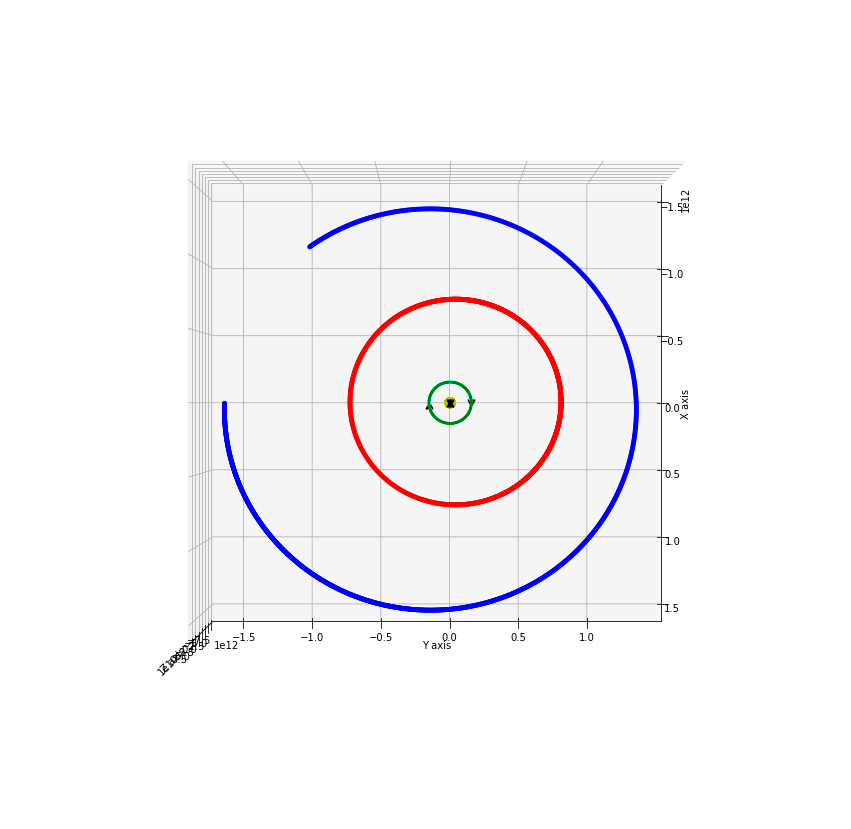

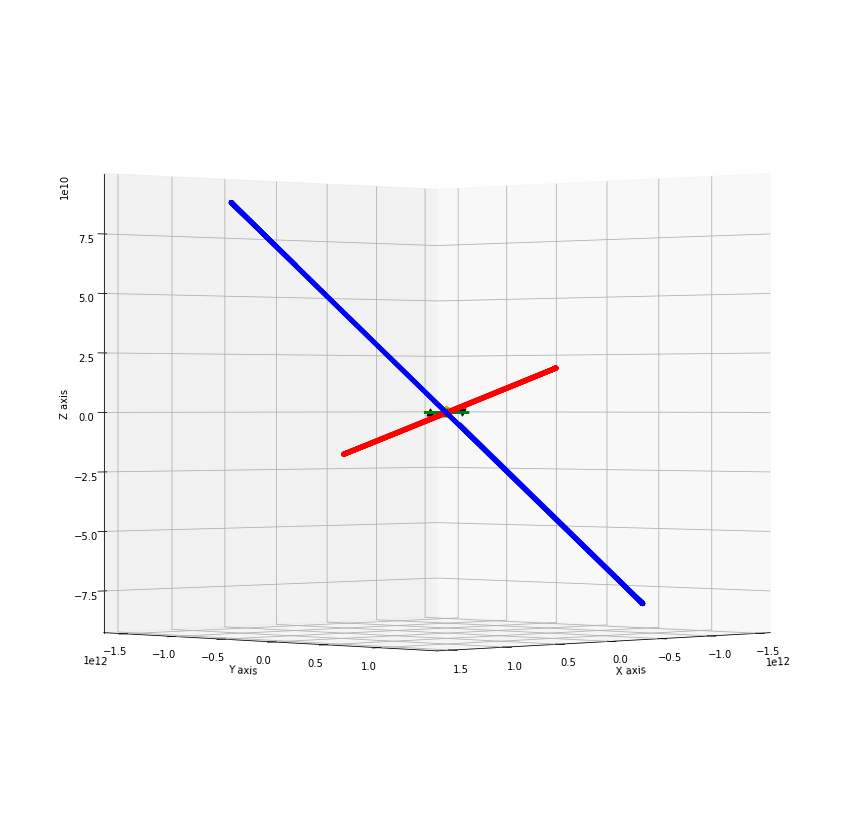

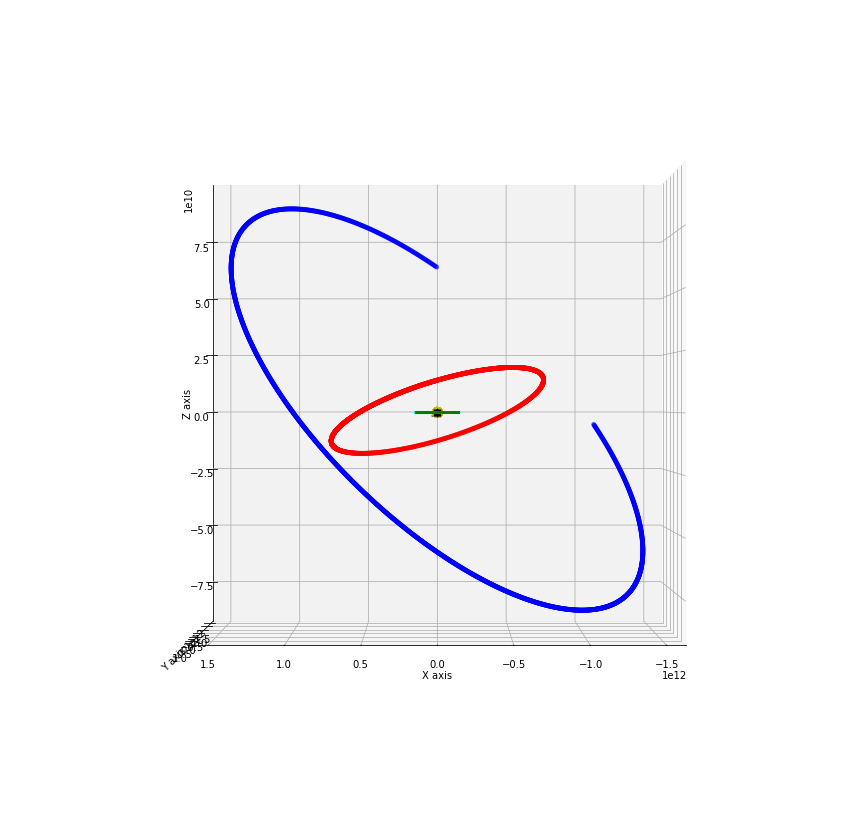

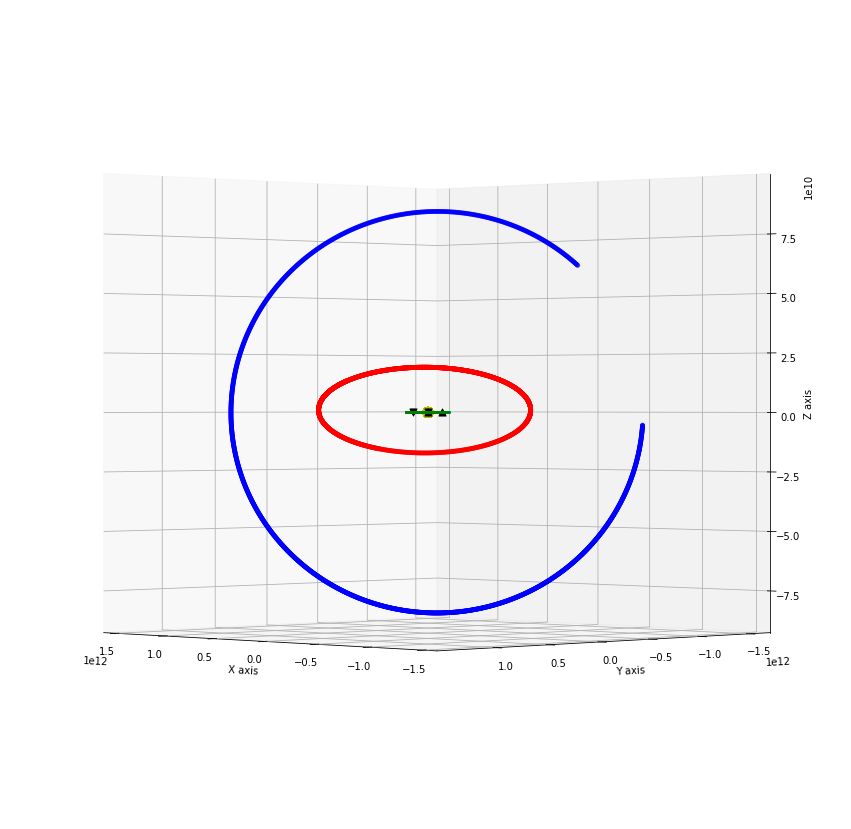

In [20]:
###########################################################################################
full_plot(bodies,0,90)
#full_plot(bodies,0,0)
full_plot(bodies,45,0)
full_plot(bodies,90,0)
full_plot(bodies,135,0)
# full_plot(bodies,180,0)
# full_plot(bodies,225,0)
# full_plot(bodies,270,0)
# full_plot(bodies,315,0)
###########################################################################################

In [16]:
for i in range(0,len(bodies)):
    print(bodies[i].year)

0
0.9727394854574479
0.00012724042274023435
0
0


Body  1  e =  0.00256  semimajor = 1.468542e+11


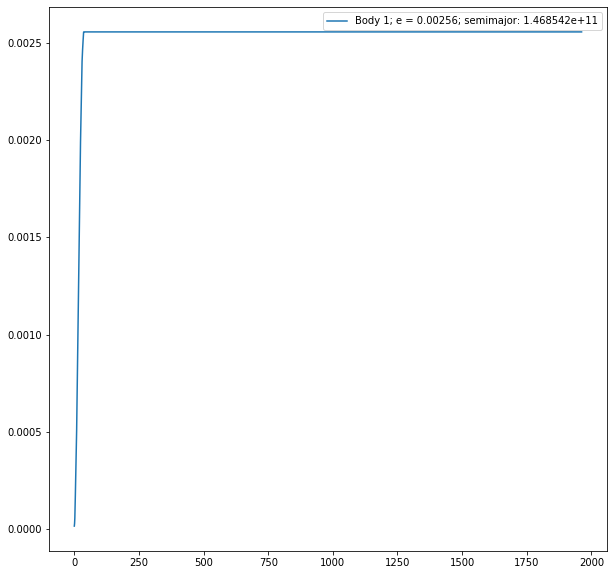

In [21]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)

for i in range(0,len(bodies)):
    if bodies[i].get_e == 1 and i == 1:
        print("Body ",bodies[i].index," e = ",np.round(bodies[i].e,5)," semimajor = "+'{:e}'.format(np.round(bodies[i].semimajor)))
        ax.plot(bodies[i].eA[:],label='Body '+str(bodies[i].index)+"; e = "+str(np.round(bodies[i].e,5))+"; semimajor: "+'{:e}'.format(bodies[i].semimajor))
plt.legend(loc='best')

1963


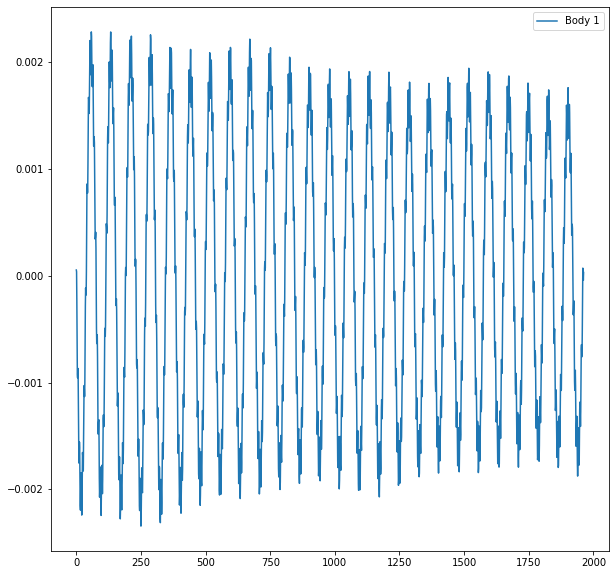

In [22]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
print(len(moon.inclinationA))

for i in range(0,len(bodies)):
    if bodies[i].get_inclination == 1 and i == 1:
        ax.plot( (np.array(bodies[i].inclinationA[:])) ,label='Body '+str(bodies[i].index))
plt.legend(loc='best')

2041


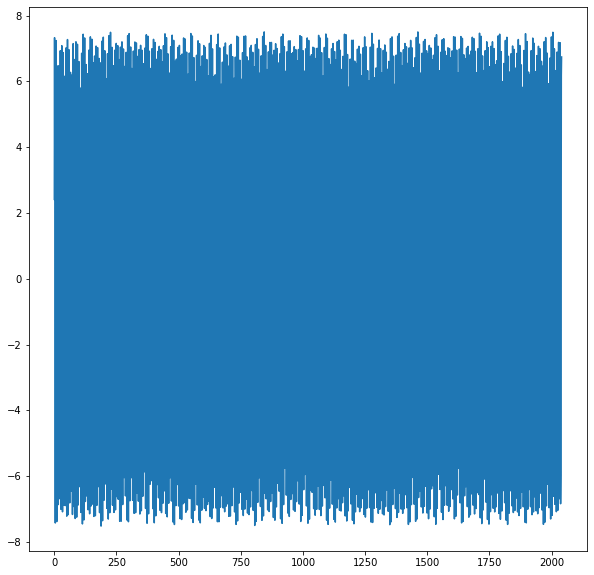

In [48]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
print(len(moon.inclinationA))

ax.plot( (np.array(planet.inclinationA) - np.array(moon.inclinationA)) )
#plt.legend(loc='best')

Text(0.5, 1.0, 'Precession vs Time')

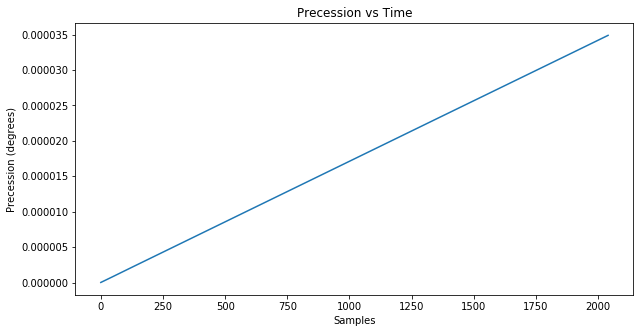

In [49]:
plt.figure(figsize=[10,5])
#t = np.linspace(0,10000*np.pi*1e7,100)

plt.plot(planet.e * np.sin(np.array(planet.precessionA)*(np.pi/180)))
plt.xlabel('Samples')
plt.ylabel('Precession (degrees)')
plt.title('Precession vs Time')

Text(0.5, 1.0, 'Obliquity vs Time')

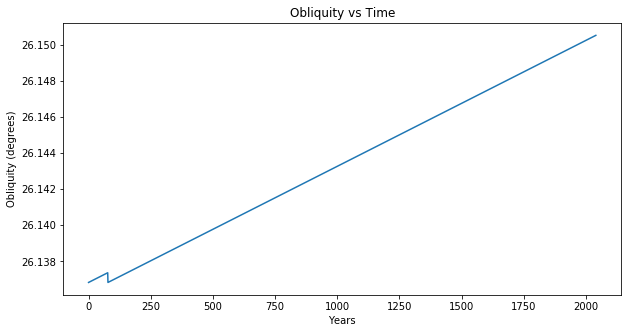

In [51]:
plt.figure(figsize=[10,5])
#t = np.linspace(0,10000*np.pi*1e7,100)

plt.plot(planet.obliq_A)
plt.xlabel('Years')
plt.ylabel('Obliquity (degrees)')
plt.title('Obliquity vs Time')

# Synthetic tests:

Text(0.5, 1.0, 'Obliquity vs Time')

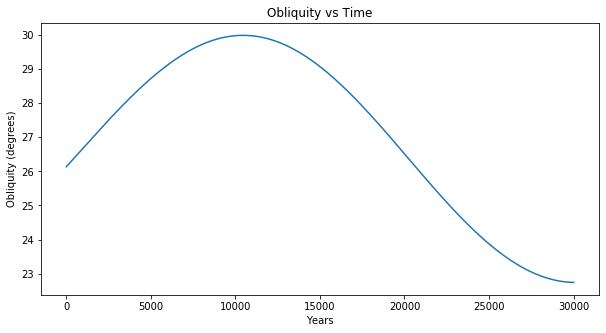

In [28]:
plt.figure(figsize=[10,5])
numyears = 30000
t_full = np.linspace(0,numyears,1000)

plt.plot(np.array(t_full),obliquity(np.array(t_full)))
plt.xlabel('Years')
plt.ylabel('Obliquity (degrees)')
plt.title('Obliquity vs Time')

Text(0.5, 1.0, 'Eccentricity vs Time')

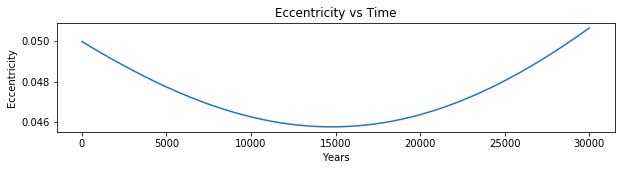

In [29]:
#Let's start by looking at how the eccentricity of the world might fluctuate over 2 million years.
num_years = 40000
#t_full = np.linspace(0,num_years,1000)

ecc_lam1 = 400000 #in years
ecc_frequency1 = 2*np.pi*(1/ecc_lam1)
ecc_amp1 = (0.05-0.00005)/2
eccentricity1 = lambda t: ecc_amp1*np.sin(ecc_frequency1*t+(8*np.pi/20))

ecc_lam2 = 95000 #in years
ecc_frequency2 = 2*np.pi*(1/ecc_lam2)
ecc_amp2 = (0.02-0.00003)/2
eccentricity2 = lambda t: ecc_amp2*np.sin(ecc_frequency2*t+(-18*np.pi/20))

ecc_lam3 = 125000 #in years
ecc_frequency3 = 2*np.pi*(1/ecc_lam3)
ecc_amp3 = (0.009-0.0002)/2
eccentricity3 = lambda t: ecc_amp3*np.sin(ecc_frequency3*t+(30*np.pi/20))

#Get a calibration constant for the normalizer. Calibration taken at t = 1e6
#eccentricity_preadjusted = lambda t: (eccentricity1(t)+eccentricity2(t)+eccentricity3(t))
#abs(min(eccentricity_preadjusted(t))+0.00005)
calibration = 0.03371921727006729
eccentricity = lambda t: (eccentricity1(t_full)+eccentricity2(t_full)+eccentricity3(t_full))+calibration

plt.figure(figsize=[10,2])
plt.plot(t_full,eccentricity(t_full))

plt.xlabel('Years')
plt.ylabel('Eccentricity')
plt.title('Eccentricity vs Time')

In [119]:
1/((0.7/10)/360)

5142.857142857143